In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

    정리해보면 우리는 FFT 알고리즘을 사용해 2D DFT로 이미지의 주파수 도메인을 찾는다. 푸리에 변환 했을 때, 주파수가 0인 요소가 좌상단에 위치하므로 분석 및 응용에 용이하게 하기 위해 이 요소를 정중앙으로 옮긴 후, HPF, LPF를 위한 마스크를 만들어 연산을 해주었다. 주파수를 조작한 후, 다시 이 요소들을 원래의 위치로 되돌리고 역 푸리에 변환을 사용해 실수부 값을 얻으면 저주파 혹은 고주파가 제거된 이미지를 얻을 수 있었다.
    
    푸리에 변환을 이용해 이미지의 경계선을 얻거나 blur 처리를 하는 연산을 진행하는 2가지 방법에 대해 살펴보았다. 기본적으로 OpenCV 함수인 dft, idft를 사용하는 것이 Numpy 함수를 사용했을 때보다 더 빠르다. 반면, Numpy 함수는 보다 사용자 친화적으로 사용할 수 있다. 그와 관련된 내용을 다루려고 한다.
----

## Performance Optimization
    
    DFT 계산 성능은 특히 일부 배열에서 성능이 더 좋다. 배열의 크기가 2의 제곱인 경우에 성능이 가장 빠르며, 크기가 2, 3, 5로 인수분해되는 배열의 경우에도 매우 효율적으로 처리할 수 있다. 그래서 만약 코드의 성능에 관련해 걱정된다면 DFT로 푸리에 변환을 하기 전에 0으로 padding하여 배열의 크기를 위의 특징을 가지도록 수정할 수 있다. 여기서 Numpy가 좀 더 사용자 친화적이게 되는 이유가 나타나는데, OpenCV의 함수를 이용할 경우에는 직접 0을 채워주어야 하지만, Numpy의 경우에는 FFT계산을 하기 위한 크기를 명시해주면 자동으로 0을 채워준다.
    
    그렇다면 DFT 계산에 최적인 배열의 크기는 어떻게 찾을 수 있을까? OpenCV의 cv2.getOptimalDFTSize() 함수를 사용할 수 있다. 이는 cv2.dft() 함수 뿐만아니라 np.fft.fft2() 두 함수에 모두 적용할 수 있다. 

In [4]:
img = cv2.imread("ryanair-5249631_1920.jpg", cv2.IMREAD_GRAYSCALE)
rows, cols = img.shape
print(rows, cols)

nrows = cv2.getOptimalDFTSize(rows)
ncols = cv2.getOptimalDFTSize(cols)
print(nrows, ncols)

1277 1920
1280 1920


## cv2.getOptimalDFTSize(vecsize) -> retval
    주어진 벡터의 크기보다 크거나 같고, DFT 연산을 수행하기에 최적인 최소 크기를 반환한다. 주어진 벡터의 크기가 너무 큰 경우에 INT_MAX를 넘어서 음수를 반환할 수도 있다.

    이미지 배열의 크기가 (1277, 1920)에서 (1280, 1920)으로 수정된 것을 확인할 수 있다. OpenCV의 함수를 활용하는 경우에는 이제 0으로 채우고 DFT 계산의 성능을 비교해보자. 먼저 0으로 가득 채운 numpy array를 만들고 여기에 데이터를 복사하거나 cv2.copyMakeBorder()를 사용할 수 있다.

In [6]:
# 1. 0으로 채운 뒤 복사
nimg = np.zeros((nrows, ncols))
nimg[:rows, :cols] = img

# 2. cv2.copyMakeBorder() 함수 이용
right = ncols - cols
bottom = nrows - rows
nimg2 = cv2.copyMakeBorder(img, 0, bottom, 0, right, cv2.BORDER_CONSTANT, value = 0)

## cv2.copyMakeBorder(src, top, bottom, left, right, borderType [, dst [, value]]) -> dst
    이미지 주변에 테두리를 형성한다. 원본 이미지를 중앙에 복사한 후, 복사된 이미지의 왼쪽, 오른쪽, 위, 아래 영역으로 뻗어나가 다른 픽셀 값으로 채운다.
    
    1. src : 원본 이미지
    2. top : top pixels
    3. bottom : bottom pixels
    4. left : left pixels
    5. right : right pixels
    (2~5 매게변수는 원본 이미지에서 각 방향으로 테두리를 얼마만큼 늘릴지를 지정하는 매게변수이다.)
    
    6. borderType : 다양한 경계선 유형을 선택할 수 있다.
    - BORDER_CONSTANT : 지정한 상수로 테두리를 채울 수 있다.
    - BORDER_REPLICATE : aaaaaa|abcdefgh|hhhhhhh
    - BORDER_REFLECT : fedcba|abcdefgh|hgfedcb
    - BORDER_WRAP : cdefgh|abcdefgh|abcdefg
    - BORDER_REFLECT_101 : gfedcb|abcdefgh|gfedcba
    - BORDER_TRANSPARENT : uvwxyz|abcdefgh|ijklmno
    (cv::BorderTypes 참고. enum 자료형이므로 0부터 상수 형태로 지정할 수도 있다.)
    7. value : borderType으로 BORDER_CONSTANT가 설정되었을 때 테두리 값을 채우기 위한 상수를 명시해야 한다.)

    이제 Numpy를 사용했을 때와 OpenCV를 사용했을 때 DFT을 비교해보자.

In [7]:
# 배열 DFT 최적화 하지 않은 상태에서 Numpy
%timeit fft1 = np.fft.fft2(img)

163 ms ± 3.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [8]:
# 배열 DFT 최적화 한 후 Numpy
%timeit fft2 = np.fft.fft2(img, [nrows, ncols])

104 ms ± 1.96 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
# 배열 DFT 최적화 하지 않은 상태에서 OpenCV
%timeit dft1 = cv2.dft(np.float32(img), flags=cv2.DFT_COMPLEX_OUTPUT)

31.1 ms ± 849 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
# 배열 DFT 최적화 한 후 OpenCV
%timeit dft2 = cv2.dft(np.float32(nimg), flags=cv2.DFT_COMPLEX_OUTPUT)

22.7 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


    비교해봤을 때, DFT 연산에 최적화 된 배열을 만드는 것이 성능을 더 좋게 만들며, OpenCV의 함수를 이용할 때 연산 속도가 더 빠른 것을 확인해볼 수 있다. 이는 단순 푸리에 변환 뿐만 아니라 역 푸리에 변환에도 적용된다.
----

## Why Laplacian is a High Pass Filter?
    [OpenCV Practice 10] Image Filtering과 [OpenCV Practice 12] Image Gradients에서 다양한 필터에 대해서 배웠다. Image Filtering과 관련된 필터들은 대부분 저주파를 통과시키는 LPF 필터이고, Image Gradients와 관련된 필터들은 고주파를 통과시키는 HPF 필터이다. Average Filter, Gaussian Filter, Sobel Filter, Scharr Filter, Prewitt Filter, Laplacian Filter에 대해 푸리에 변환을 하여 실제로 LPF 필터인지, HPF 필터인지 확인해보자.

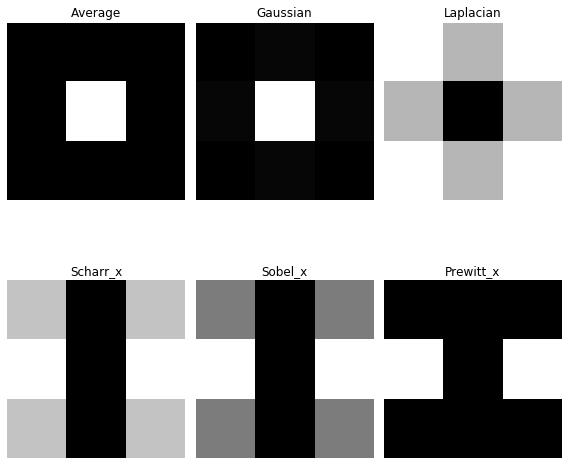

In [13]:
# averaging filter
average = np.ones((3, 3))

# gaussian filter
x = cv2.getGaussianKernel(3, 3)
gaussian = x * x.T

# scharr filter
scharr_x = np.array([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]])

# sobel filter
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

# prewitt filter
prewitt_x = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])

# laplacian filter
laplacian = np.array([[0, 1, 0], [1, -4, 1], [0, 1, 0]])

filters = [average, gaussian, laplacian, scharr_x, sobel_x, prewitt_x]
titles = ["Average", "Gaussian", "Laplacian", "Scharr_x", "Sobel_x", "Prewitt_x"]

fft_filters = [np.fft.fft2(x) for x in filters]
fft_shift = [np.fft.fftshift(x) for x in fft_filters]
mag_spectrum = [np.log(np.abs(x) + 1) for x in fft_shift]

plt.figure(figsize=(8, 8))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(mag_spectrum[i], cmap = "gray")
    plt.title(titles[i])
    plt.axis("off")
    
plt.tight_layout()
plt.show()

    그림에서 흰색 부분은 통과되는 주파수 영역이고, 검은 부분은 필터링 되는 주파수 영역이다. Average와 Gaussian부분의 필터는 가운데 저주파 영역을 통과 시키므로 이 필터를 썼을 때는 전반적으로 blur처리가 된다. Scharr_x, Sobel_x, Prewitt_x는 가운데 부분와 윗부분이 필터링 되고 양 옆의 고주파 영역을 통과 시키므로 이 필터를 썼을 때는 수평선 부분은 없어지는 대신 수직선 부분에 대한 경계선을 탐지할 수 있다. Laplacian 필터는 가운데의 저주판 부분을 필터링 시키고 그 외 고주파 영역은 통과되므로 전반적인 경계선을 탐지할 수 있다. 이 정보를 통해 각 커널이 HPF인지, LPF 인지 확인할 수 있다.